In [51]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

cancer = load_breast_cancer()

data = cancer.data
target = cancer.target
feature_names = cancer.feature_names

# 데이터 프레임 생성
df = pd.DataFrame(data=data, columns=feature_names)
df['target'] = target

# 모델 생성 목적을 암을 예측하기 위해서 만들 것이라서 종양을 0으로, 암을 1로 바꿔주기
tumor = df.loc[df['target'] == 1].copy()
cancer = df.loc[df['target'] == 0].copy()

tumor['target'] = 0
cancer['target'] = 1

sample = pd.concat([tumor, cancer[:30]], sort=True)

sample['target'].value_counts()

target
0    357
1     30
Name: count, dtype: int64

훈련 / 테스트 분할

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    sample.drop("target", axis=1),
    sample['target'],
    random_state=42
)

In [53]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 10000)
model.fit(X_train, y_train)

lr_pred = model.predict(X_test)

정확도 확인

In [54]:
from sklearn.metrics import accuracy_score

# 정확도 확인
accuracy_score(y_test, lr_pred)

0.9690721649484536

In [55]:
# 잘못된 예측 정확도
#   돌팔이 의사가 "암인 사람도 얼마 없는데, 그냥 다 종양(0)이라고 해버릴까?"
dolpal_pred = np.zeros(shape=y_test.shape)
dolpal_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [56]:
accuracy_score(y_test, dolpal_pred)

0.9072164948453608

오차 행렬(혼동 행렬 - Confusion Matrix)로 확인하기

In [57]:
from sklearn.metrics import confusion_matrix

lr_conf_matrix = confusion_matrix(y_test, lr_pred)

dolpal_conf_matrix = confusion_matrix(y_test, dolpal_pred)

In [58]:
print("모델의 오차 행렬 : \n{}".format(lr_conf_matrix))
print()
print("돌팔이의 오차 행렬 : \n{}".format(dolpal_conf_matrix))

모델의 오차 행렬 : 
[[87  1]
 [ 2  7]]

돌팔이의 오차 행렬 : 
[[88  0]
 [ 9  0]]


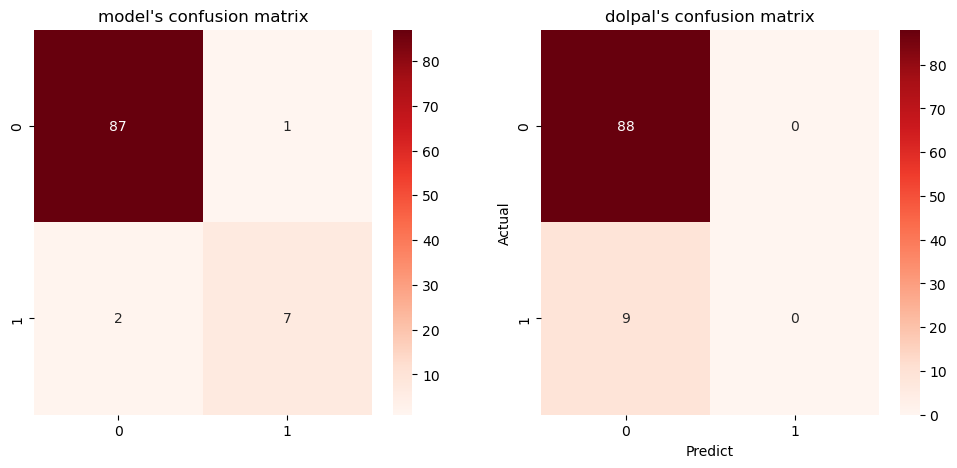

In [59]:
# 오차 행렬 시각화 - 히트맵
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 5))
plt.subplot(121)
ax = sns.heatmap(
    lr_conf_matrix,
    annot=True,
    cmap="Reds"
)
ax.set_title("model's confusion matrix")

plt.subplot(122)
ax = sns.heatmap(
    dolpal_conf_matrix,
    annot=True,
    cmap="Reds",
)

ax.set_title("dolpal's confusion matrix")

plt.xlabel("Predict")
plt.ylabel("Actual")
plt.show()

## 정밀도, 재현율 확인
- 정밀도(Precision) : TP / (FP + TP)
    - 양성(Positive)로 예측 했을 때 실제 맞은 비율
- 재현율(Recall) : TP / (FN + TP)
    - 실제 양성인 데이터를 맞춘 비율

In [60]:
from sklearn.metrics import precision_score, recall_score

In [61]:
print("정밀도 : {:.3f}".format(precision_score(y_test, lr_pred)))
print("재현율 : {:.3f}".format(recall_score(y_test, lr_pred)))

정밀도 : 0.875
재현율 : 0.778


In [62]:
# 돌팔이의 정밀도, 재현율
print("정밀도 : {:.3f}".format(precision_score(y_test, dolpal_pred)))
print("재현율 : {:.3f}".format(recall_score(y_test, dolpal_pred)))

정밀도 : 0.000
재현율 : 0.000


c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


정밀도 / 재현율 Trade off

In [63]:
# LogisticRegression의 예측 확률(predict_proba) 확인
lr_pred_proba = model.predict_proba(X_train)
lr_pred_proba[:3]

array([[9.99999918e-01, 8.15929206e-08],
       [9.99999981e-01, 1.94969809e-08],
       [1.00000000e+00, 1.06415612e-10]])

In [64]:
lr_pred[:3] # 결정론적 해석 : hard prediction

array([0, 0, 0], dtype=int64)

## Binarizer 클래스 사용하기
- 지정한 Threshold(임계값)보다 작으면 0으로, 크면 1로 분류해주는 클래스
- 기본 Threshold는 0.0

In [65]:
from sklearn.preprocessing import Binarizer

sample_data = [[0.1, 0.7],
               [1.1, 0.2],
               [0.3, 1.2]]

binarizer = Binarizer(threshold=0.5)
binarizer.fit_transform(sample_data)

array([[0., 1.],
       [1., 0.],
       [0., 1.]])

In [66]:
binarizer = Binarizer(threshold=0.8)
binarizer.fit_transform(sample_data)

array([[0., 0.],
       [1., 0.],
       [0., 1.]])

In [67]:
# predict_proba는 2차원 행렬이 나옴
#  1번 클래스일 확률 정보만 얻기
lr_pred_proba_1 = model.predict_proba(X_test)[:, 1].reshape(-1,1)
lr_pred_proba_1[:3]

array([[7.24679675e-04],
       [6.82907318e-04],
       [1.33798716e-08]])

In [68]:
binarizer = Binarizer(threshold = 0.9)

# 1번 클래스일 확률 정보에서, 0.5를 넘으면 1, 0.5를 못 넘으면 0
custom_predict = binarizer.fit_transform(lr_pred_proba_1)

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test, pred, ax=None):
  confusion = confusion_matrix(y_test, pred)
  precision = precision_score(y_test , pred)
  recall = recall_score(y_test , pred)
  accuracy = accuracy_score(y_test, pred)
  hmap_ax = sns.heatmap(
    confusion,
    annot=True,
    cmap="Reds",
    ax=ax
  )
  hmap_ax.set_title('A: {0:.4f}, P: {1:.4f}, R: {2:.4f}'.format(accuracy , precision ,recall))

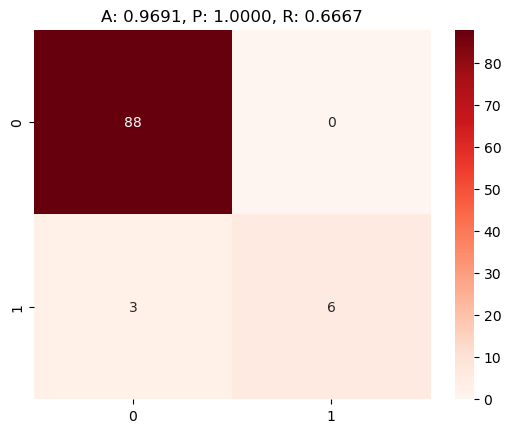

In [70]:
get_clf_eval(y_test, custom_predict)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


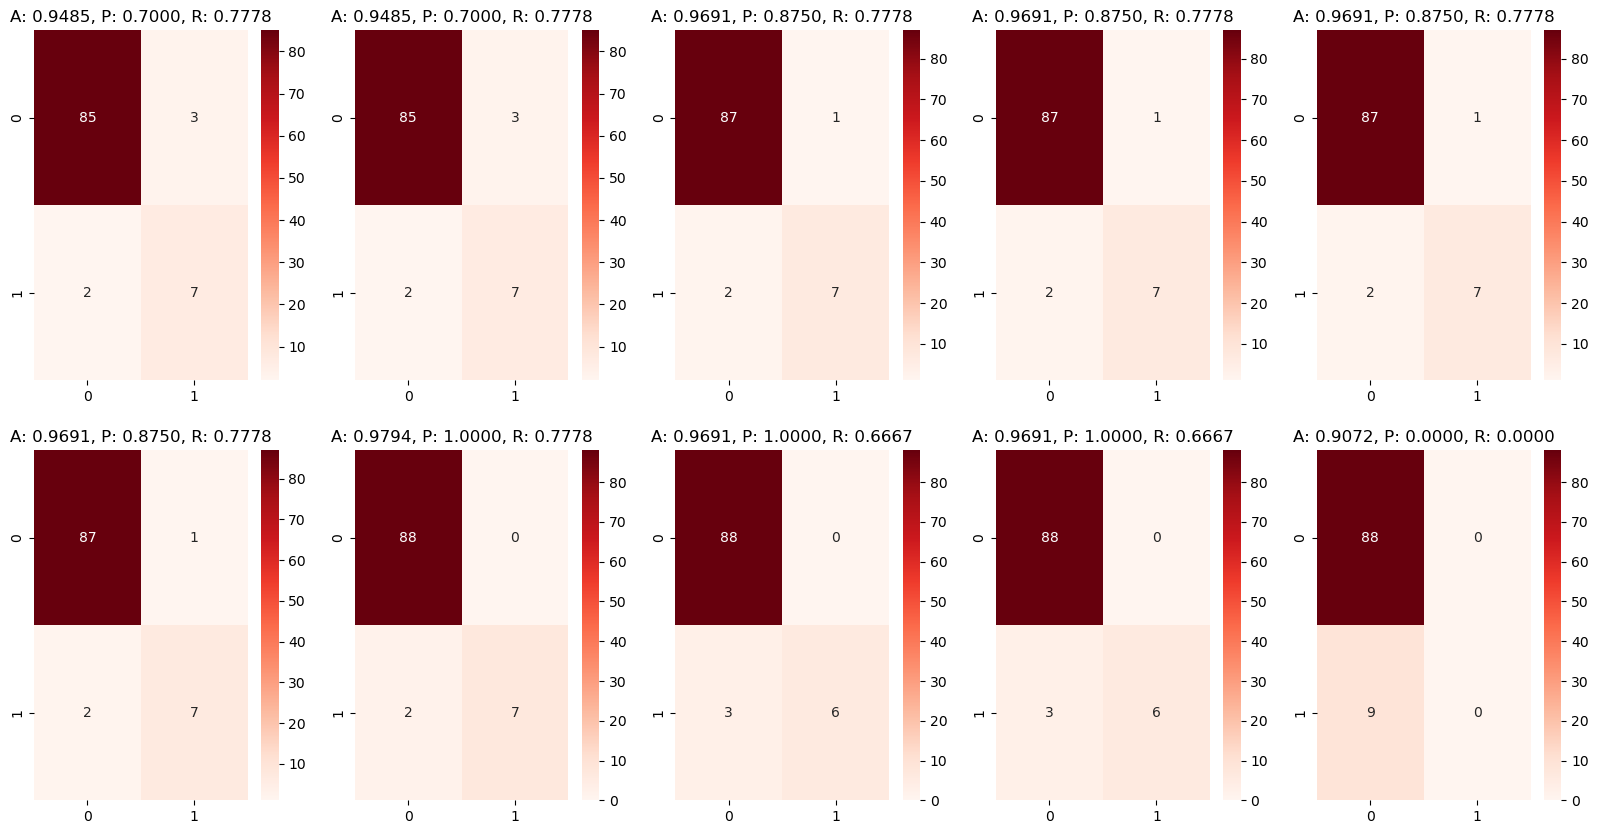

In [71]:
def get_eval_by_threshold(y_test, pred_proba, thresholds):
    fig, axes = plt.subplots(nrows=2, ncols=5)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold, ax in zip(thresholds, axes.ravel()):
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba)

        custom_predict = binarizer.transform(pred_proba)
        get_clf_eval(y_test, custom_predict, ax)

# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
get_eval_by_threshold(y_test, lr_pred_proba_1, thresholds )

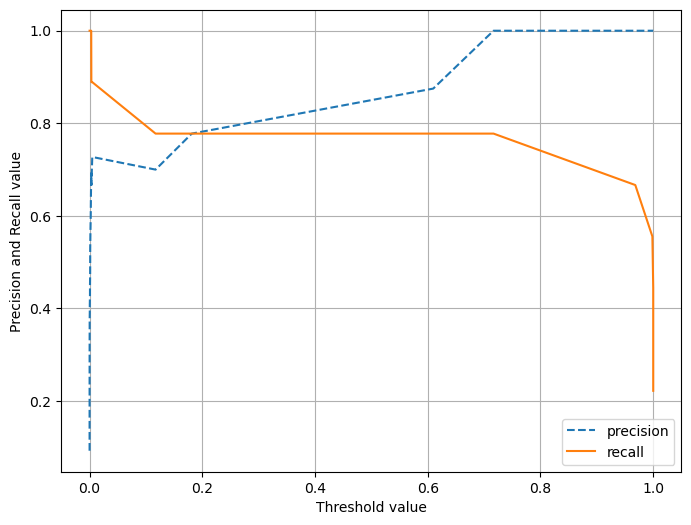

In [72]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot( y_test, model.predict_proba(X_test)[:, 1] )

F1 스코어

c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


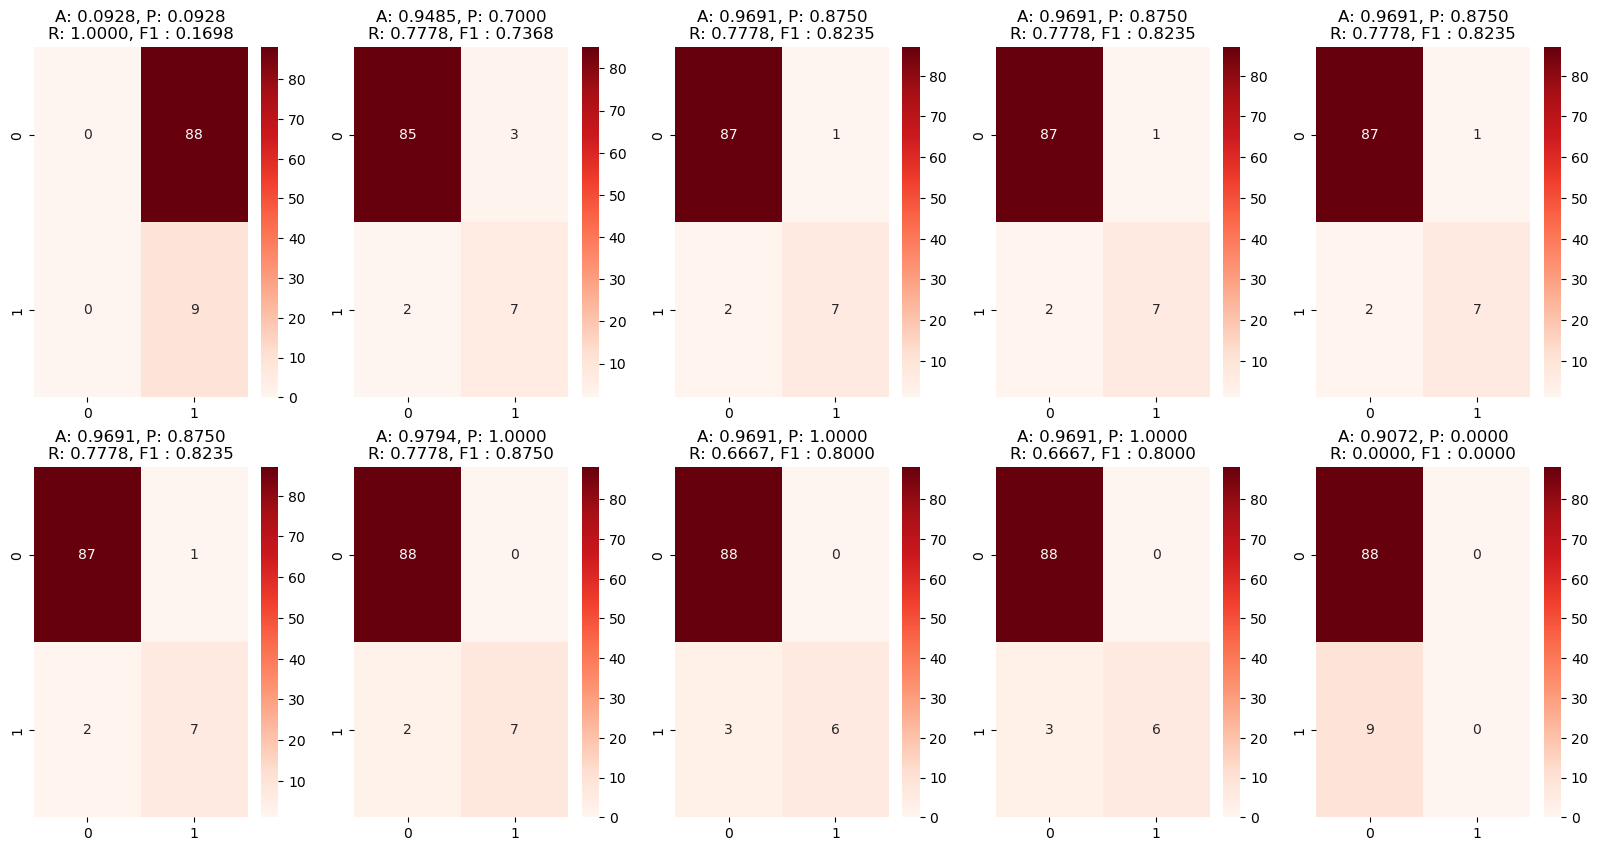

In [78]:
from sklearn.metrics import f1_score

def get_clf_eval(y_test, pred, ax=None):
  confusion = confusion_matrix( y_test, pred)
  precision = precision_score(y_test , pred)
  recall = recall_score(y_test , pred)
  accuracy = accuracy_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  hmap_ax = sns.heatmap(
    confusion,
    annot=True,
    cmap="Reds",
    ax=ax
  )

  hmap_ax.set_title('A: {0:.4f}, P: {1:.4f}\nR: {2:.4f}, F1 : {3:.4f}'.format(accuracy , precision ,recall, f1))

thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
pred_proba = model.predict_proba(X_test)
get_eval_by_threshold(y_test, lr_pred_proba_1, thresholds)

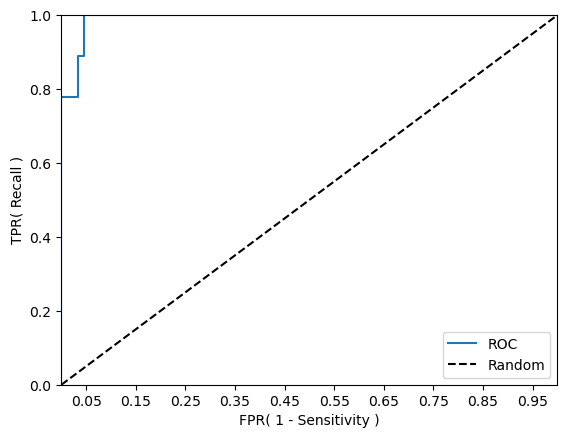

In [ ]:
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음.
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림.6
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

roc_curve_plot(y_test, model.predict_proba(X_test)[:, 1] )